# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import torch
import cv2

from blazebase import resize_pad, denormalize_detections
from blazepose import BlazePose
from blazepose_landmark import BlazePoseLandmark
from blazeface import BlazeFace
from blazepalm import BlazePalm
from blazeface_landmark import BlazeFaceLandmark
from blazehand_landmark import BlazeHandLandmark

from visualization import draw_detections, draw_landmarks, draw_roi, POSE_CONNECTIONS,HAND_CONNECTIONS


In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.6.0
CUDA version: 10.2
cuDNN version: 7605


In [4]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

## Load the model

In [6]:
face_detector = BlazeFace().to(gpu)
face_detector.load_weights("blazeface.pth")
face_detector.load_anchors("anchors_face.npy")

torch.onnx.export(
    face_detector, 
    (torch.randn(1,3,128,128, device='cuda'), ), 
    "blazeface.onnx",
    input_names=("input", ),
    output_names=("preds", "conf"),
    opset_version=10
)

In [7]:
palm_detector = BlazePalm().to(gpu)
palm_detector.load_weights("blazepalm.pth")
palm_detector.load_anchors("anchors_palm.npy")
palm_detector.min_score_thresh = .75

torch.onnx.export(
    palm_detector, 
    (torch.randn(1,3,256,256, device='cuda'), ), 
    "blazepalm.onnx",
    input_names=("input", ),
    output_names=("preds", "conf"),
    opset_version=10
)

In [17]:
hand_regressor = BlazeHandLandmark().to(gpu)
hand_regressor.load_weights("blazehand_landmark.pth")

torch.onnx.export(
    hand_regressor, 
    (torch.randn(1,3,256,256, device='cuda'), ), 
    "blazehand_landmark.onnx",
    input_names=("input", ),
    output_names=("hand_conf", "handed","landmarks"),
    opset_version=11
)

/home/mulong/codes/Models_Zoo/MediaPipePyTorch/blazehand_landmark.py:90: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[0] == 0:
/home/mulong/miniconda3/envs/open_model_zoo/lib/python3.6/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [18]:
face_regressor = BlazeFaceLandmark().to(gpu)
face_regressor.load_weights("blazeface_landmark.pth")

torch.onnx.export(
    face_regressor, 
    (torch.randn(1,3,192,192, device='cuda'), ), 
    "blazeface_landmark.onnx",
    input_names=("input", ),
    output_names=("face_conf", "landmarks"),
    opset_version=10
)

/home/mulong/codes/Models_Zoo/MediaPipePyTorch/blazeface_landmark.py:65: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[0] == 0:


In [20]:
pose_detector = BlazePose().to(gpu)
pose_detector.load_weights("blazepose.pth")
pose_detector.load_anchors("anchors_pose.npy")

torch.onnx.export(
    pose_detector, 
    (torch.randn(1,3,128,128, device='cuda'), ), 
    "blazepose.onnx",
    input_names=("input", ),
    output_names=("preds", "conf"),
    opset_version=10
)

In [22]:
pose_regressor = BlazePoseLandmark().to(gpu)
pose_regressor.load_weights("blazepose_landmark.pth")

torch.onnx.export(
    pose_regressor, 
    (torch.randn(1,3,256,256, device='cuda'), ), 
    "blazepose_landmark.onnx",
    input_names=("image", ),
    output_names=("flag", "landmarks","seg"),
    opset_version=11
)

/home/mulong/codes/Models_Zoo/MediaPipePyTorch/blazepose_landmark.py:177: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if batch == 0:
/home/mulong/miniconda3/envs/open_model_zoo/lib/python3.6/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## Make a prediction

The input image should be 64x64. BlazeFace will not automatically resize the image, you have to do this yourself!

In [ ]:
WINDOW='test'
cv2.namedWindow(WINDOW)
capture = cv2.VideoCapture(0)

if capture.isOpened():
    hasFrame, frame = capture.read()
    frame_ct = 0
else:
    hasFrame = False

while hasFrame:
    frame_ct +=1

    frame = np.ascontiguousarray(frame[:,::-1,::-1])

    img1, img2, scale, pad = resize_pad(frame)

    normalized_face_detections = face_detector.predict_on_image(img2)
    normalized_palm_detections = palm_detector.predict_on_image(img1)

    face_detections = denormalize_detections(normalized_face_detections, scale, pad)
    palm_detections = denormalize_detections(normalized_palm_detections, scale, pad)


    xc, yc, scale, theta = face_detector.detection2roi(face_detections)
    img, affine, box = face_regressor.extract_roi(frame, xc, yc, theta, scale)
    flags, normalized_landmarks = face_regressor(img)
    landmarks = face_regressor.denormalize_landmarks(normalized_landmarks, affine)


    xc, yc, scale, theta = palm_detector.detection2roi(palm_detections)
    img, affine2, box2 = hand_regressor.extract_roi(frame, xc, yc, theta, scale)
    flags2, handed2, normalized_landmarks2 = hand_regressor(img)
    landmarks2 = hand_regressor.denormalize_landmarks(normalized_landmarks2, affine2)
    

    for i in range(len(flags)):
        landmark, flag = landmarks[i], flags[i]
        if flag>.5:
            draw_landmarks(frame, landmark[:,:2], size=1)


    for i in range(len(flags2)):
        landmark, flag = landmarks2[i], flags2[i]
        if flag>.5:
            draw_landmarks(frame, landmark[:,:2], HAND_CONNECTIONS, size=2)

    draw_roi(frame, box)
    draw_roi(frame, box2)
    draw_detections(frame, face_detections)
    draw_detections(frame, palm_detections)

    cv2.imshow(WINDOW, frame[:,:,::-1])
    # cv2.imwrite('sample/%04d.jpg'%frame_ct, frame[:,:,::-1])

    hasFrame, frame = capture.read()
    key = cv2.waitKey(1)
    if key == 27:
        break

capture.release()
cv2.destroyAllWindows()

In [6]:
img = cv2.imread("test_eye.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))

In [8]:
eye_gpu, iris_gpu = net.predict_on_image(img)
eye = eye_gpu.cpu().numpy()
iris = iris_gpu.cpu().numpy()
print(eye.shape)
iris.shape

(1, 71, 3)


(1, 5, 3)

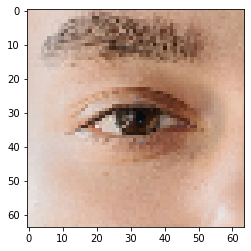

In [9]:
plt.imshow(img, zorder=1)
x, y = iris[:, :, 0], iris[:, :, 1]
plt.scatter(x, y, zorder=2, s=1.0)
plt.show()

Let's convert model to ONNX format

In [11]:
torch.onnx.export(
    net, 
    (torch.randn(1,3,64,64, device='cuda'), ), 
    "irislandmarks.onnx",
    input_names=("image", ),
    output_names=("preds", "conf"),
    opset_version=10
)